In [1]:
import os

#Change working directory to /Users/albertvong/Documents/Argonne/PtychoPINN/
os.chdir('/home/av_linux/PtychoPINN')

In [2]:
import numpy as np
import importlib

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset

import ptycho.tf_helper as tf_hh
import ptycho_torch.helper as pt_hh

import matplotlib.pyplot as plt


2024-10-14 13:33:49.796888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 13:33:49.796944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 13:33:49.797642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 13:33:49.803102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 13:33:50.887376: W tensorflow/compiler/tf2

No GPU found, using CPU instead.
1 items had no tests:
    __main__
0 tests in 1 items.
0 passed and 0 failed.
Test passed.


# We'll be using a random set of tensors to check if the functionalities of the forward model for both tensorflow and pytorch are consistent.

## All tensorflow functions without assertions

In [93]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda

In [94]:
reassemble_patches_tf = Lambda(lambda x: tf_hh.reassemble_patches(x[0], fn_reassemble_real=tf_hh.mk_reassemble_position_real(x[1])))

In [95]:
gridsize = 2

In [96]:
def extract_patches_position(imgs: tf.Tensor, offsets_xy: tf.Tensor, jitter: float = 0.) -> tf.Tensor:
    """
    Expects offsets_xy in channel format.

    imgs must be in flat format with a single image per solution region, i.e.
    (batch size, M, M, 1) where M = N + some padding size.

    Returns shifted images in channel format, cropped symmetrically

    no negative sign
    """
    if  imgs.get_shape()[0] is not None:
        assert int(imgs.get_shape()[0]) == int(offsets_xy.get_shape()[0])
    assert int(imgs.get_shape()[3]) == 1
    assert int(offsets_xy.get_shape()[2]) == 2
    assert int(imgs.get_shape()[3]) == 1
    gridsize = 2
    assert int(offsets_xy.get_shape()[3]) == gridsize**2
    offsets_flat = tf_hh.flatten_offsets(offsets_xy)
    stacked = tf.repeat(imgs, gridsize**2, axis = 3)
    flat_padded = tf_hh._channel_to_flat(stacked)
    channels_translated = tf_hh.trim_reconstruction(
        tf_hh.Translation()([flat_padded, offsets_flat, jitter]))
    return channels_translated

## All pytorch setup

In [7]:
from ptycho_torch.config_params import TrainingConfig, DataConfig, ModelConfig

In [8]:
data_config_default = {
    'nphotons': 1e5,
    'N': 128,
    'C': 4,
    'K': 6,
    'n_subsample': 10,
    'grid_size': (2,2),
    'probe_dir_get': True,
}


model_config_default = {
    'intensity_scale_trainable': True,
    'max_position_jitter': 10, #Random jitter for translation (helps make model more robust)
    'n_filters_scale': 2, #Shrinking factor for channels
    'intensity_scale': 15000.0, #General intensity scale guess, this can be trainable. Needs to be float
    'object.big': True, #True if need patch reassembly
    'probe.big': True, #True if need patch reassembly
    'offset': 4,
    'loss_function': 'Poisson'
}

training_config_default = {
    'nll': True, #Negative log likelihood for loss function
    'device': 'cuda'
}

t_config, d_config, m_config = TrainingConfig(), DataConfig(), ModelConfig()

t_config.set_settings(training_config_default)
d_config.set_settings(data_config_default)
m_config.set_settings(model_config_default)

# Setting fixed matrices to pass through forward pass

Assume that we have just passed through the autoencoder, which produces a random stack of solution regions with amplitude and phase.

In [9]:
#Fix rng seed
np.random.seed(42)

#Random valued image tensors
x_amp = np.random.randn(4, 4, 128, 128).astype('float32')
x_phi = np.random.randn(4, 4, 128, 128).astype('float32')

#Random valued positions
pos = np.random.uniform(low=-20, high = 20,
                        size = (4, 4, 1, 2)).astype('float32')


In [10]:
#First test with pytorch

#Convert x_amp from numpy to pytorch array

x_amp_pt = torch.from_numpy(x_amp)
x_phi_pt = torch.from_numpy(x_phi)

pos_pt = torch.from_numpy(pos)

x_combined_pytorch = pt_hh.combine_complex(x_amp_pt, x_phi_pt)




In [11]:
#Now test with tensorflow
#Need to re-arrange matrices so channel dimension is last (for tensorflow)
x_amp_t = np.transpose(x_amp, (0,2,3,1))
x_phi_t = np.transpose(x_phi, (0,2,3,1))

pos_t = np.transpose(pos, (0,2,3,1))

x_amp_tf = tf.convert_to_tensor(x_amp_t)
x_phi_tf = tf.convert_to_tensor(x_phi_t)
pos_tf = tf.convert_to_tensor(pos_t)

x_combined_tf = tf_hh.combine_complex(x_amp_tf, x_phi_tf)


In [123]:
#Check whether the combined tensors are identical first (checking combine_complex)

x_combined_pt_np = x_combined_pytorch.numpy()
x_combined_tf_np = x_combined_tf.numpy()

x_combined_tf_np = np.transpose(x_combined_tf_np, (0,3,1,2))

diff_combined_abs = np.abs(x_combined_pt_np) - np.abs(x_combined_tf_np)

np.max(diff_combined_abs)

4.7683716e-07

Now reassembling tensors in both pt and tf to check for equality

In [112]:
import importlib
import ptycho_torch
import ptycho
importlib.reload(ptycho_torch.helper)
importlib.reload(ptycho.tf_helper)

import ptycho_torch.helper as pt_hh
import ptycho.tf_helper as tf_hh

No GPU found, using CPU instead.


In [86]:
reassembled_patch_pytorch = pt_hh.reassemble_patches_position_real(x_combined_pytorch, pos_pt)

reassembled_patch_tf = reassemble_patches_tf([x_combined_tf, pos_tf])

In [119]:
#Checking consistency
pt_version = reassembled_patch_pytorch.numpy()
tf_version = reassembled_patch_tf.numpy()

#Transpose tf version
tf_version_np = np.transpose(tf_version, (0,3,1,2)).squeeze()

pt_version.shape, tf_version_np.shape


((4, 142, 142), (4, 142, 142))

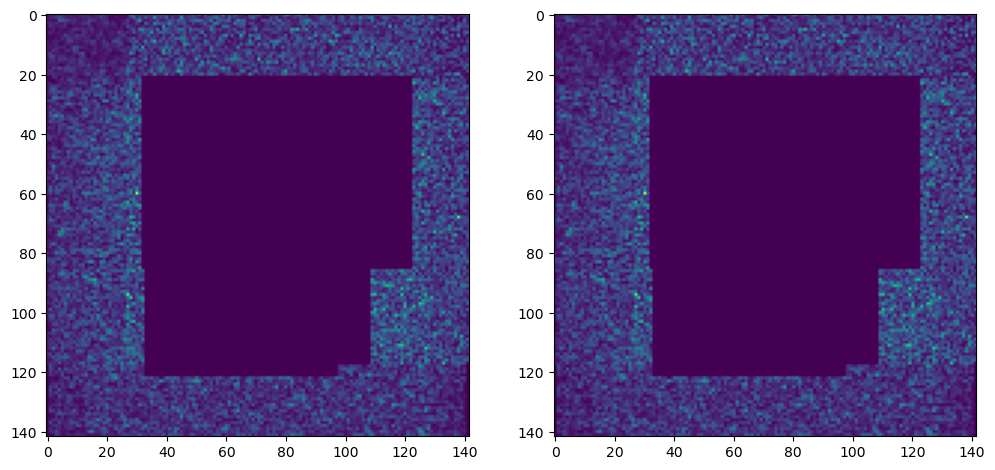

In [99]:
#Plot two plots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot the first plot on the left
axs[0].imshow(np.abs(pt_version[1]))
axs[1].imshow(np.abs(tf_version_np[1]))

In [126]:
pt_reass = np.abs(pt_version[0])
tf_reass = np.abs(tf_version_np[0])

diff = pt_reass - tf_reass

max_index = np.unravel_index(np.argmax(diff), diff.shape)

pt_reass[max_index[0], max_index[1]]

1116.1495

I think the differences in values my chalk up to how exactly the translation function is implemented in tensorflow vs pytorch. These qualitatively look similar to each other, but ultimately there are minute details.

It looks like here, the biggest differences exist outside the actual overlapped region. The differences get blown up due to division by a very small number (mk_norm mask) so the difference value of ~0.3-0.4 is super tiny and not relevant

## Now testing the region extraction portion of the pass

In [113]:
extracted_patches_tf = extract_patches_position(reassembled_patch_tf, pos_tf)
extracted_patches_tf = tf_hh._flat_to_channel(extracted_patches_tf)

extracted_patches_pt = pt_hh.extract_channels_from_region(reassembled_patch_pytorch[:,None,:,:], pos_pt)

In [114]:
#Again convert to numpy for comparison (cuz channel dimension mismatch)
pt_version = extracted_patches_pt.numpy()
tf_version = extracted_patches_tf.numpy()

#Transpose tf version
tf_version = np.transpose(tf_version, (0,3,1,2)).squeeze()

pt_version.shape, tf_version.shape

((4, 4, 128, 128), (4, 4, 128, 128))

Text(0.5, 1.0, 'difference')

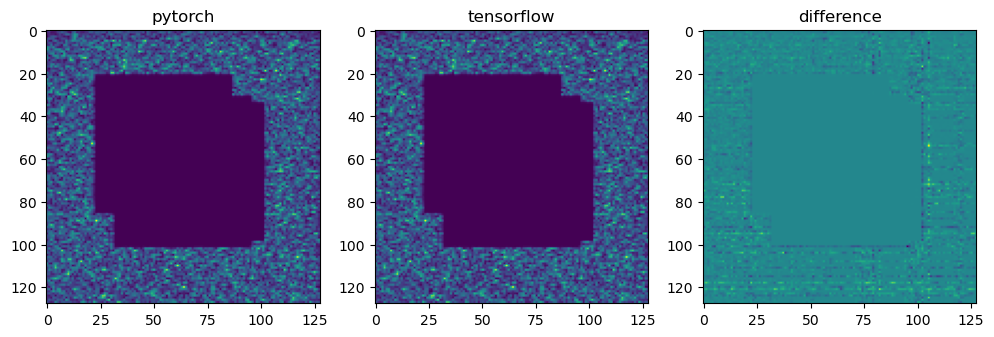

In [116]:
#Plot two plots side by side
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
pt_plot = np.abs(pt_version[0,1])
tf_plot = np.abs(tf_version[0,1])
diff_plot = pt_plot - tf_plot
# Plot the first plot on the left
axs[0].imshow(pt_plot)
axs[0].set_title('pytorch')
axs[1].imshow(tf_plot)
axs[1].set_title('tensorflow')
axs[2].imshow(diff_plot)
axs[2].set_title('difference')

In [118]:
np.max(diff_plot)

0.039794922